## ngboost_models 

Ngboost is a python package that implements a Natural Gradient Boosting that provides **probabilist predictions** instead of point predictions as done by other famous machine learning models such as LightGBM, Xgboost, and other scikit-learn based models. You can find more information about the package and the methodology used in the documentation: 
https://github.com/stanfordmlgroup/ngboost

In forecast analysis, it's essential to have information about the uncertainty of the predictions. For this reason, this module was developed. The functions explained in this section were used to generate the results available in this dashboard: http://epigraphhub.org/covidch/

Let's import the necessary packages: 

In [1]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt
os.chdir('/Users/eduardoaraujo/Documents/GitHub/epigraphhub_py')
from epigraphhub.data.get_data import get_cluster_data, get_georegion_data
from epigraphhub.models.ngboost_models import *
os.chdir('/Users/eduardoaraujo/Documents/GitHub/epigraphhub_py/examples')

First, let's download a dataset from our platform to use as an example. To do this, we will use the function `get_cluster_data`. This function, by default, is configured to work well with the Switzerland covid data. In the example below, the result will be a data frame with a datetime index. The columns are related to the time series of tests, cases, and hospitalizations in Geneva and your first and second-order differences.

In [2]:
%%time
df = get_cluster_data('switzerland', ['foph_test_d', 'foph_cases_d', 'foph_hosp_d'], ['GE'], vaccine = False)

df

CPU times: user 128 ms, sys: 17.9 ms, total: 146 ms
Wall time: 10.3 s


,test_GE,diff_test_GE,diff_2_test_GE,cases_GE,diff_cases_GE,diff_2_cases_GE,hosp_GE,diff_hosp_GE,diff_2_hosp_GE
datum,,,,,,,,,
2020-03-01,0.000000,0.000000,0.000000,1.428571,0.142857,0.142857,0.428571,0.000000,0.000000
2020-03-02,0.000000,0.000000,0.000000,1.714286,0.285714,0.428571,0.428571,0.000000,0.142857
2020-03-03,0.000000,0.000000,0.000000,1.714286,0.000000,0.285714,0.428571,0.000000,0.000000
2020-03-04,0.000000,0.000000,0.000000,1.714286,0.000000,0.000000,0.571429,0.142857,0.142857
2020-03-05,0.000000,0.000000,0.000000,1.857143,0.142857,0.142857,0.857143,0.285714,0.428571
...,...,...,...,...,...,...,...,...,...
2022-05-06,859.000000,-8.142857,-16.142857,143.000000,-7.142857,-16.428571,4.285714,-0.285714,-0.285714
2022-05-07,858.000000,-1.000000,-9.142857,139.428571,-3.571429,-10.714286,3.428571,-0.857143,-1.142857
2022-05-08,856.285714,-1.714286,-2.714286,139.571429,0.142857,-3.428571,3.000000,-0.428571,-1.285714


### Function  `rolling_predictions()`:

To see the performance of a ngboost model in our data, we can use the rolling_predictions function. This function will split our data into train and test data and return a data frame with the predicted values, the predictions' confidence interval and target values, and a datetime index.

This function has the following parameters: 

* `target_name`: Name of the target column. This column should belong to the dataset `data`. Type = `string`;
* `data`: Dataframe with features and target column. Type= `pandas dataframe`;
* `ini_date`: Determines the beginning of the training dataset. Type = `string`;
* `split`: Determines which percentage of the data will be used to train the model. Type = `float`. Default = 'split';
* `horizon_forecast`: Determines the number of days that will be predicted. Type = `int`. Default = 14;
* `max_lag`: Determines the number of the last days used as features to forecast the next days. Type = `int`. Default = 14; 
* `parameters_model`: dictionary with the parameters that will be used in the ngboost regressor model. Type: `dictionary`. Default = {
    "Base": default_tree_learner,
    "Dist": LogNormal,
    "Score": LogScore,
    "natural_gradient": True,
    "verbose": False,
    "col_sample": 0.9,
    "n_estimators": 30,
    "learning_rate": 0.1,
    "validation_fraction": 0.15,
    "early_stopping_rounds": 50,}.

According to the ngboost documentation, a ngboost model accepts the following parameters: 
* `Dist`: assumed distributional form of Y|X=x. A distribution from ngboost.distns, e.g Normal;
* `Score`: rule to compare probabilistic predictions P̂ to the observed data y. A score from ngboost.scores, e.g. LogScore;
* `Base`: base learner to use in the boosting algorithm. Any instantiated sklearn regressor, e.g. DecisionTreeRegressor();
* `natural_gradient`: logical flag indicating whether the natural gradient should be used;
* `n_estimators`: the number of boosting iterations to fit;
* `learning_rate`: the learning rate;
* `minibatch_frac`: the percent subsample of rows to use in each boosting iterating;
* `verbose`: flag indicating whether the output should be printed during fitting;
* `verbose_eval`: increment (in boosting iterations) at which output should be printed;
* `tol`: numerical tolerance to be used in optimization;
* `random_state`: seed for reproducibility. See https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn;
* `validation_fraction`: Proportion of training data to set aside as validation data for early stopping;
* `early_stopping_rounds`: The number of consecutive boosting iterations during which the loss has to increase before the algorithm stops early. Set to `None` to disable early stopping and validation. None enables running over the full data set.

and the returns:
* df_pred. DataFrame with the target values and the predictions. The data frame has the following columns: `target`, with the values used to train and test the model, 	`lower`, with the lower value of the confidence interval of the predictions,`median` with the median values of the predictions,	`upper`, with the upper value of the confidence interval, `train_size`, with the number of target observations used to train the model. Type: `pandas Dataframe`.
* models: dictionary with the models trained. The key value is the number of days ahead that the model was trained to predict. Type:`dictionary`. 
* X_train: pandas data frame with features used training the model. Type: `pandas Dataframe`
* targets: dictionary with the target values. The key value is the number of days ahead in relation to the index in the array of values.Type: `dictionary`. 

In [3]:
%%time
params_model = {
    "Base": default_tree_learner,
    "Dist": LogNormal,
    "Score": LogScore,
    "natural_gradient": True,
    "verbose": False,
    "col_sample": 0.9,
    "n_estimators": 30,
    "learning_rate": 0.1,
    "validation_fraction": 0.15,
    "early_stopping_rounds": 50,
}

df_pred, models, X_train, targets = rolling_predictions('hosp_GE', df, ini_date = '2020-08-01',split=0.75,
    horizon_forecast=14, maxlag=14, kwargs=params_model,)


CPU times: user 8.28 s, sys: 26.3 ms, total: 8.3 s
Wall time: 8.31 s


### Function  `plot_predicted_vs_data()`:

This function can be used to plot the data frame with the predictions obtained in the `rolling_predictions()` function. The function has the following parameters: 

* `df_pred`. It's a pandas Dataframe obtained in the function `rolling_predictions()`. Type = `pandas Dataframe`;
* `title`. It's the string that will be used as the plot's title. Type = `string`. Default = 'Ngboost predictions';
* `save`. If `True`, the plot will be saved. Type = `boolean`. Default = False;
* `filename` It's the string with the name that will be used to save the plot. Type = `string`. Default = 'ngboost_pred';
* `path` It's the string with the path that will be used to save the plot.Type = `string`. Default = None.

The return is None. 


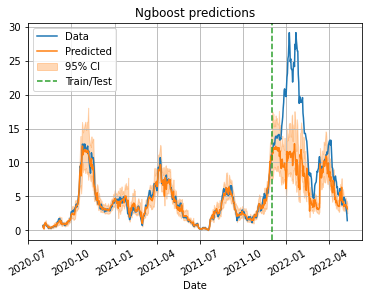

In [4]:
plot_predicted_vs_data(df_pred,save = True)

### Function  `training_model()`:

We can use the `training_model()` function to train a model with all the available data. This function will train a model with all the data available and return a dictionary with all the models trained. This function also allows the user to save the models trained in a specific path. The trained models are saved with the name `ngboost_{target_name}_{T}D.joblib`, with T in the range(1, horizon_forecast).

This function has the following parameters: 

* `target_name`: Name of the target column. This column should belong to the dataset `data`. Type = `string`;
* `data`: Dataframe with features and target column. Type= `pandas Dataframe`;
* `ini_date`: Determines the beginning of the training dataset. Type = `string`;
* `horizon_forecast`: Determines the number of days that will be predicted. Type = `int`. Default = 14;
* `max_lag`: Determines the number of the last days used as features to forecast the next days. Type = `int`. Default = 14; 
* `save`. If `True` the models will be saved. Type = `boolean`. Default = True;
* `path` It's the string with the path that will be used to save the models. Type = `string`. Default = "../opt/models/saved_models/ml".
* `kwargs`: dictionary with the parameters that will be used in the ngboost regressor model. Type: `dictionary`. Default = {
    "Base": default_tree_learner,
    "Dist": LogNormal,
    "Score": LogScore,
    "natural_gradient": True,
    "verbose": False,
    "col_sample": 0.9,
    "n_estimators": 30,
    "learning_rate": 0.1,
    "validation_fraction": 0.15,
    "early_stopping_rounds": 50,}.
    
    
The returns is:
* model: dictionary with the models trained. The key value is the number of days ahead that the model was trained to predict. Type:`dictionary`. 

In [5]:
target_name = 'hosp_GE'
data = df 
horizon = 16
lag = 14
models = training_model(
    target_name,
    data,
    ini_date="2020-03-01",
    horizon_forecast=horizon,
    maxlag=lag,
    save=True,
    path="saved_ngboost",
    kwargs=params_model)

### Function `rolling_forecast()`:

This function forecasts a time series using, like features, the last observation of the `data` param and the **saved** models trained with `training_model()`. The `horizon_forecast` and `maxlag` parameters should be the same used in the `training_model()`. 

This function will return a Dataframe with the following columns: `lower`, with the lower value of the confidence interval of the predictions,`median` with the median values of the predictions,	`upper`, with the upper value of the confidence interval, and a datetime index.

This function has the following parameters:

* `target_name` Name of the target column, this column should belong to the dataset data. Type = string;
* `data`: Dataframe with features and target column. Type= pandas Dataframe;,
* `horizon_forecast`:  Determines the number of days that will be predicted. Type = `int`. Default = 14;
* `maxlag`: Determines the number of the last days used as features to forecast the next days. Type = `int`. Default = 14;
* `path`: It's the string with the path that will be used to save the models.Type = `string`. Default="../opt/models/saved_models/ml".

The return is:

* `df_for`: DataFrame with the forecasted values. T he data frame has the column `lower`, with the lower value of the confidence interval of the predictions,`median` with the median values of the predictions,	`upper`, with the upper value of the confidence interval, .The dataframe also have a datetime index. Type: `pandas Dataframe`.


In [6]:
df_for = rolling_forecast(
    target_name,
    data,
    horizon_forecast=horizon,
    maxlag=lag,
    path="saved_ngboost",)

In [7]:
df_for

,lower,median,upper
date,,,
2022-05-11,0.857785,1.491056,2.591846
2022-05-12,1.285970,1.845438,2.648305
2022-05-13,1.124466,1.637436,2.384418
2022-05-14,1.135357,1.651211,2.401443
2022-05-15,1.310740,1.922101,2.818617
2022-05-16,1.224936,1.894504,2.930068
2022-05-17,0.990534,1.661595,2.787281
2022-05-18,1.255427,2.038247,3.309194
2022-05-19,1.570224,2.333239,3.467026


### Function  `plot_forecast()`:

This function can be used to plot the data frame with the forecast obtained in the `rolling_forecast()` function. It's also necessary to provide a dataset with the data before the forecasted values (the same dataset provided in the `data` parameter of the `rolling_forecast()` function). The function has the following parameters: 

* `df`: It's a pandas Dataframe with the data used to make the forecast. Type = `pandas dataframe`. 
  
* `target_name`: Name of the target column forecasted. Type = `string`. 

* `df_for`: It's a dataframe  with the forecasted values, it's must have the following columns: lower, median, upper and a datetime index. Type = `pandas Dataframe`.  
                    
* `last_values`: Number of last values of the df show in the plot. Type = `int`. Default = 90. 
          
* `title`: This string is used as the plot's title. Type = `string`. Default = `Ngboost forecast`. 
 
* `save`: If true the plot is saved. Type = `boolean`. Default = False
    
* `filename`: Name of the png file where the plot is saved. Type = `string`. Default = `ngboost_forecast`.  
    
* `path`: Path where the figure must be saved. If None the figure is saved in the current directory. Type = `string|None`. Default = None. 


The return is None. 
    

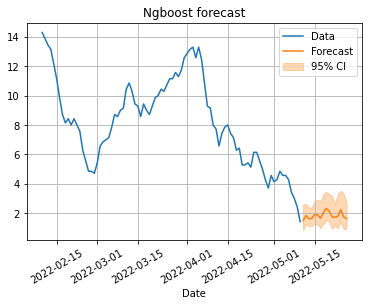

In [8]:
plot_forecast(df, target_name, df_for, last_values = 90, title = 'Ngboost forecast', save = False, filename = 'ngboost_forecast', path = None)


In [9]:
df_for

,lower,median,upper
date,,,
2022-05-11,0.857785,1.491056,2.591846
2022-05-12,1.285970,1.845438,2.648305
2022-05-13,1.124466,1.637436,2.384418
2022-05-14,1.135357,1.651211,2.401443
2022-05-15,1.310740,1.922101,2.818617
2022-05-16,1.224936,1.894504,2.930068
2022-05-17,0.990534,1.661595,2.787281
2022-05-18,1.255427,2.038247,3.309194
2022-05-19,1.570224,2.333239,3.467026
